In [ ]:
!pip install -r requirementsTraining.txt

## LIBRERIE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
%matplotlib inline

## IMPORT DEI DATI

In [4]:
test=pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [5]:
train['No-show'].replace("No", 0,inplace=True)
train['No-show'].replace("Yes", 1,inplace=True)

test['No-show'].replace("No", 0,inplace=True)
test['No-show'].replace("Yes", 1,inplace=True)

## CONTROLLO DATASET

Controllo l'assenza di campi Nan, Null, Duplicati


In [6]:
missing_data_train = test.isnull().sum(axis=0).reset_index()
missing_data_train
missing_data_test = test.isnull().sum(axis=0).reset_index()
missing_data_test

,index,0
0,No-show,0
1,PatientId,0
2,AppointmentID,0
3,Gender,0
4,ScheduledDay,0
5,AppointmentDay,0
6,Age,0
7,Neighbourhood,0
8,Scholarship,0
9,Hipertension,0


In [7]:
NaN_data_train = train.isna().sum(axis=0).reset_index()
NaN_data_train
NaN_data_test = test.isna().sum(axis=0).reset_index()
NaN_data_test

,index,0
0,No-show,0
1,PatientId,0
2,AppointmentID,0
3,Gender,0
4,ScheduledDay,0
5,AppointmentDay,0
6,Age,0
7,Neighbourhood,0
8,Scholarship,0
9,Hipertension,0


In [8]:
duplicates = train.duplicated(['AppointmentID'], keep=False).sum(axis=0)
print(duplicates)
duplicatesT = test.duplicated(['AppointmentID'], keep=False).sum(axis=0)
print(duplicatesT)

0
0


## CORRETTEZZA DATASET

In [9]:
if train.Age.isnull().sum(axis=0) > 0:
    print(train.Age.isnull().sum(axis=0))
    dataset = train.Age.fillna(train.Age.median())

In [10]:
if test.Age.isnull().sum(axis=0) > 0:
    print(test.Age.isnull().sum(axis=0))
    dataset = test.Age.fillna(test.Age.median())

In [11]:
if train.Gender.isnull().sum(axis=0) > 0:
    print(train.Gender.isnull().sum(axis=0))
    train = train.Gender.fillna(0)

In [12]:
if test.Gender.isnull().sum(axis=0) > 0:
    print(test.Gender.isnull().sum(axis=0))
    test = test.Gender.fillna(0)

In [13]:
if train["No-show"].isnull().sum(axis=0) > 0:
    print(train["No-show"].isnull().sum(axis=0))
    train = train["No-show"].dropna()

In [14]:
if test["No-show"].isnull().sum(axis=0) > 0:
    print(test["No-show"].isnull().sum(axis=0))
    test = test["No-show"].dropna()

### Controllo età minima e massima 

#### Tengo solamente valori di età compresi tra 0 e 100 ( non ha senso tenere valori più alti di 100, dato che poche persone arrivano a quell'età)
#### Ovviamente, vengono scartati anche eventuali valori negativi

In [15]:
min_age = train.Age.min()
print("min-age:", min_age)
max_age = train.Age.max()
print("max-age:", max_age)

min_ageT = test.Age.min()
print("min-age:", min_ageT)
max_ageT = test.Age.max()
print("max-age:", max_ageT)

min-age: 0
max-age: 115
min-age: 0
max-age: 115


In [16]:
train = train[(train.Age >= 0) & (train.Age <= 100)]
test = test[(test.Age >= 0) & (test.Age <= 100)]

### Conversione formato date

In [17]:
train['ScheduledDay'] = pd.to_datetime(train['ScheduledDay'])
train['AppointmentDay'] = pd.to_datetime(train['AppointmentDay'])
test['ScheduledDay'] = pd.to_datetime(test['ScheduledDay'])
test['AppointmentDay'] = pd.to_datetime(test['AppointmentDay'])

## Aggiunta feature AwaitingTime

E' il tempo di attesa di un paziente per la sua prossima visita. Viene calcolato tramite differenza tra il giorno dell appuntamento ed il giono di prenotazione. AwaitingTime potrebbe essere incisivo sulla predizione dal momento che è stancante aspettare troppo tempo.

In [18]:
train['AwaitingTime'] = train["AppointmentDay"].sub(train["ScheduledDay"], axis=0)
train["AwaitingTime"] = (train["AwaitingTime"] / np.timedelta64(1, 'D')).abs()

test['AwaitingTime'] = test["AppointmentDay"].sub(test["ScheduledDay"], axis=0)
test["AwaitingTime"] = (test["AwaitingTime"] / np.timedelta64(1, 'D')).abs()

### Aggiungo la feature "NumeroAppuntamentiMancati" per ogni paziente

Ogni paziente può avere più visite. Per ogni visita è registrato se il paziente si è presentato o meno. Potrebbe essere molto importante per la predizione calcolare il numero degli appuntamenti mancati per ogni paziente.

In [19]:
train['MissedAppo'] = train.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())
test['MissedAppo'] = test.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())

### Tolgo le features meno significative

PatientId ed AppointmentId non sono chiaramente features significative affinchè un paziente si presenti o meno ad un appuntamento. ScheduleDay e AppointmentDay le ho utilizzate per ricavarmi una nuova feature, AwaitingTime (ovvero i giorni di attesa di un paziente dalla sua prossima visita), a mio parere significativa.

In [20]:
train.drop(['PatientId','AppointmentID','ScheduledDay','Handcap','AppointmentDay','Neighbourhood'], axis=1, inplace = True)

In [21]:
test.drop(['PatientId','AppointmentID','ScheduledDay','Handcap','AppointmentDay','Neighbourhood'], axis=1, inplace = True)

In [22]:
X = train[['Gender', 'Diabetes','Hipertension', 'Scholarship', 'SMS_received','Age', 'AwaitingTime','MissedAppo']]

In [23]:
X_ = test[['Gender', 'Diabetes','Hipertension', 'Scholarship', 'SMS_received','Age', 'AwaitingTime','MissedAppo']]

In [24]:
y = train['No-show']

In [25]:
y_ = test['No-show']

In [26]:
y=y.astype('int')

In [27]:
y_=y.astype('int')

In [28]:
X_train1 = pd.get_dummies(X)

## APPRENDIMENTO DEL MODELLO

### Ridimensionamento dei dati in modo che tutti i valori siano compresi tra 0 e 1.

In [29]:
scaler = StandardScaler().fit(X_train1)
rescaledX2 = scaler.transform(X_train1)

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(rescaledX2, y, test_size=0.3, random_state = 42)

tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train2, y_train2)

y_pred2 = tree.predict(X_test2)

print('Accuracy-training-subset: {:.2f}'.format(tree.score(X_train2, y_train2)))
print('Accuracy-test-subset: {:.2f}'.format(tree.score(X_test2, y_test2)))

Accuracy-training-subset: 0.94
Accuracy-test-subset: 0.93


## IMPORTANZA DELLE FEATURES

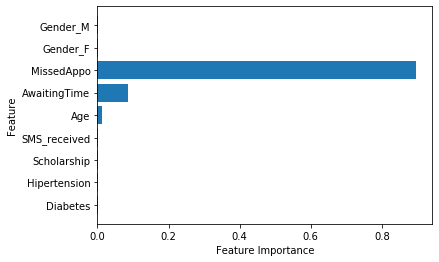

In [31]:
n_features = X_train1.shape[1]

plt.barh(range(n_features), tree.feature_importances_, )
plt.yticks(np.arange(n_features), X_train1)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()